# Grayscale Image

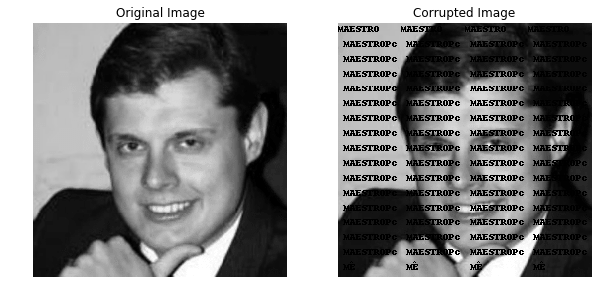

In [113]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import requests
import numpy as np

# Load the images.
# You can place your favorite picture here. The test image has resolution 256x256, 
# that's corresponds to the icon size in google image search
url = 'https://c.tcdn.co/0fb/9ba/0fb9ba42-d5ed-11e8-88d0-866420764000/channel256.png'

image = Image.open(requests.get(url, stream=True).raw)
image = image.convert('L')

def corrupt_image(image, text):
  l = len(text) 
  w,h = image.size

  n_ws = int(w/(8*l))
  n_hs = int(h/(16))
  string = ''
  for i in range(n_hs):
    string += text + '\n '
  for i in range(n_ws):
    ImageDraw.Draw(
              image  # Image
              ).text(
                  (int((i/n_ws)*w), 0),  # Coordinates
                  string,  # Text
                  (0)  # Color
              )
  return image

u_orig = np.array(image).astype(np.uint8)
image = corrupt_image(image, 'MAESTRO')

u_corr = np.array(image).astype(np.uint8)
rows, cols = u_orig.shape

# known is 1 if the pixel is known,
# 0 if the pixel was corrupted.
known = np.zeros((rows, cols))
for i in range(rows):
    for j in range(cols):
         if u_corr[i, j] != 0:
            known[i, j] = 1

%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(u_orig, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(u_corr, cmap='gray');
ax[1].set_title("Corrupted Image")
ax[1].axis('off');
fig.savefig('start.png')

In [114]:
# Recover the original image using total variation in-painting.
import cvxpy as cp

U = cp.Variable(shape=(rows, cols))
obj = cp.Minimize(cp.tv(U))
constraints = [cp.multiply(known, U) == cp.multiply(known, u_corr)]
prob = cp.Problem(obj, constraints)

# Use SCS to solve the problem.
prob.solve(verbose=True, solver=cp.SCS)
print("optimal objective value: {}".format(obj.value))

----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 377885
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 130561, constraints m = 260611
Cones:	primal zero / dual free vars: 65536
	soc vars: 195075, soc blks: 65025
Setup time: 8.01e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.62e+21  5.60e+21  1.00e+00 -2.09e+28  4.68e+26  4.20e+27  7.86e-02 
   100| 1.42e-03  2.33e-03  2.09e-04  4.08e+05  4.07e+05  2.55e-10  1.06e+01 
   200| 1.83e-04  3.14e-04  4.37e-05  4.08e+05  4.08e+05  1.54e

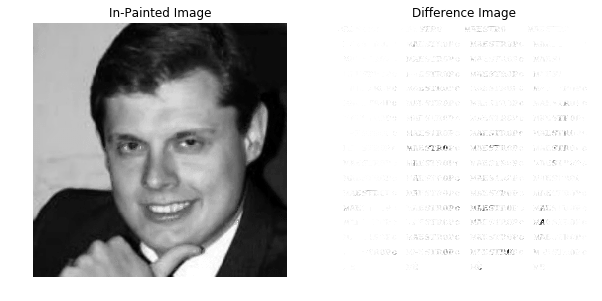

In [115]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Display the in-painted image.
ax[0].imshow(U.value, cmap='gray');
ax[0].set_title("In-Painted Image")
ax[0].axis('off')

img_diff = 10*np.abs(u_orig - U.value)
ax[1].imshow(-img_diff, cmap='gray');
ax[1].set_title("Difference Image")
ax[1].axis('off');
fig.savefig('finish.png')

# Color Image

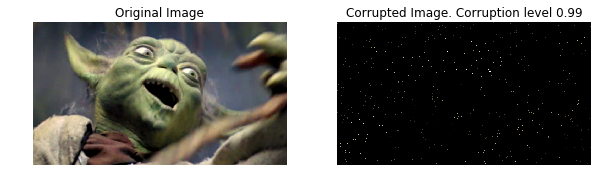

In [97]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import requests
import numpy as np

# Load the images.
# You can place your favorite picture here. The test image has resolution 256x256, 
# that's corresponds to the icon size in google image search
url = 'https://geekandsundry.com/wp-content/uploads/2016/11/Game-5.png'

# CORRUPTION LEVEL between 0 (no corruption at all) and 1 (black pixels only)
corruption = 0.99

image = Image.open(requests.get(url, stream=True).raw)
image = image.convert('RGB')
image = np.array(image)

def corrupt_image(image, level=0.707):
  w,h,c = image.shape
  mask = np.random.random((w,h)) > level
  for channel in range(c):
    image[:,:, channel] = mask*image[:,:, channel]
  return image

u_orig = image.copy()
u_corr = corrupt_image(image, corruption)


# known is 1 if the pixel is known,
# 0 if the pixel was corrupted.
w,h,c = image.shape
known = np.zeros((w,h))
for i in range(w):
    for j in range(h):
         if u_corr[i, j].all() != np.array([0, 0, 0]).all():
            known[i, j] = 1

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(u_orig, cmap='gray');
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(u_corr);
ax[1].set_title("Corrupted Image. Corruption level {}".format(corruption))
ax[1].axis('off');
fig.savefig('tv_start4.png')

In [98]:
# Recover the original image using total variation in-painting.
import cvxpy as cp

variables = []
constraints = []
for i in range(c):
    U = cp.Variable(shape=(w,h))
    variables.append(U)
    constraints.append(cp.multiply(known, U) == cp.multiply(known, u_corr[:, :, i]))

prob = cp.Problem(cp.Minimize(cp.tv(*variables)), constraints)
prob.solve(verbose=True, solver=cp.SCS)
print("optimal objective value: {}".format(prob.value))

WARN: A->p (column pointers) not strictly increasing, column 1055785 empty
WARN: A->p (column pointers) not strictly increasing, column 1584435 empty
WARN: A->p (column pointers) not strictly increasing, column 2113085 empty
----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 6868467
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 2113086, constraints m = 5275902
Cones:	primal zero / dual free vars: 1585950
	soc vars: 3689952, soc blks: 527136
Setup time: 5.40e+01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


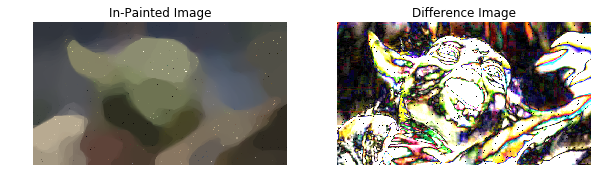

In [99]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

u_restored = np.zeros((w,h,c))
u_restored[:,:,0], u_restored[:,:,1], u_restored[:,:,2] = [variables[0].value, variables[1].value, variables[2].value]
u_restored = u_restored.astype(int)
fig, ax = plt.subplots(1, 2,figsize=(10, 5))
ax[0].imshow(u_restored)
ax[0].set_title("In-Painted Image")
ax[0].axis('off')

img_diff = 10 * np.abs(u_orig - u_restored)
ax[1].imshow(img_diff)
ax[1].set_title("Difference Image")
ax[1].axis('off')
fig.savefig('tv_finish4.png')